In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from time import time, sleep
import os
import re
np.set_printoptions(threshold=np.inf)



# Exploration

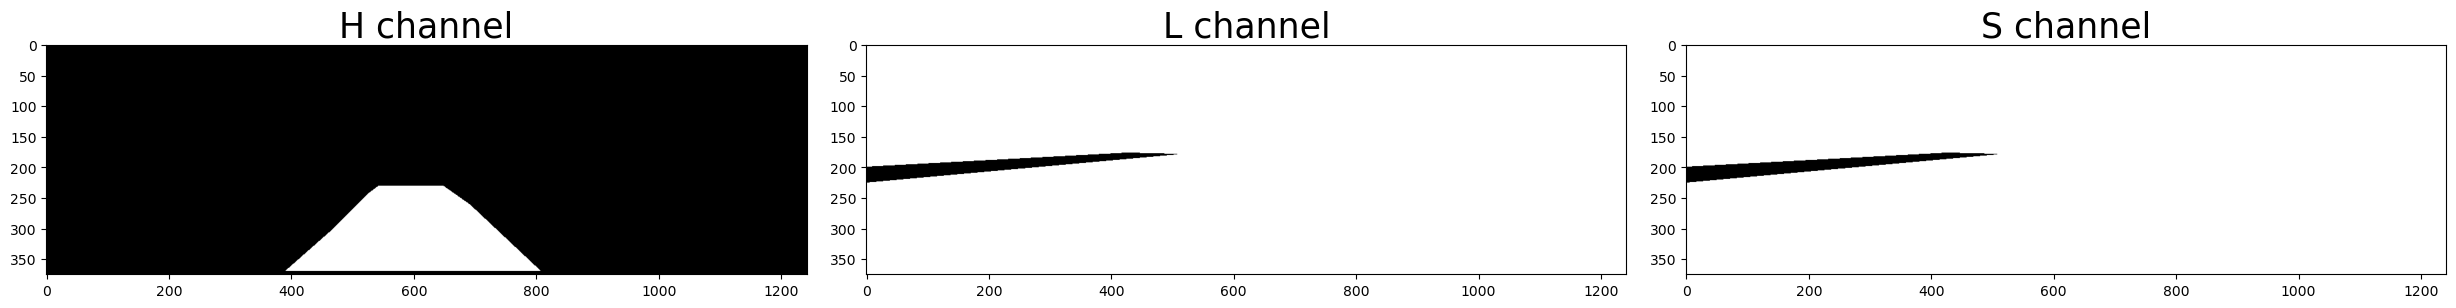

In [29]:
image = mpimg.imread('./data/training/gt_image_2/um_lane_000007.png')

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls[:,:,0], cmap='gray')
ax1.set_title('H channel', fontsize=25)
ax2.imshow(hls[:,:,1], cmap='gray')
ax2.set_title('L channel', fontsize=25)
ax3.imshow(hls[:,:,2], cmap='gray')
ax3.set_title('S channel', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

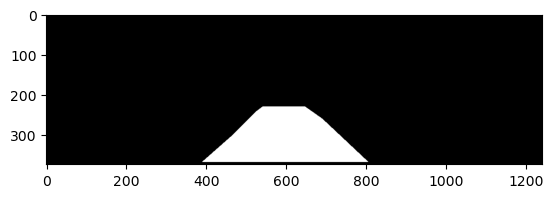

In [31]:
image = mpimg.imread('./data/training/gt_image_2/um_lane_000007.png')
HEIGHT=image.shape[0]
WIDTH=image.shape[1]
def RGB2BIN(image):
    '''
    converts RGB images to binary image from the hue channal of the hsv color space
    inputs: RGB image
    outputs: uint8 binary image
    '''
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    binary_output = np.zeros_like(hsv[:,:,0])
    binary_output[hsv[:,:,0] > 1]= 1
    binary_output=binary_output.astype(np.uint8)#this type is needed for later operations on the image
    return binary_output
plt.imshow(RGB2BIN(image),cmap='gray')

In [17]:
def mask_to_polygon(mask: np.array, report: bool = False):
    
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for object in contours:
        coords = []

        for point in object:
            coords.append(int(point[0][0]))
            coords.append(int(point[0][1]))
        polygons.append(coords)
    
    if report:
        print(f"Number of points = {len(polygons[0])}")
    
    return np.array(polygons).ravel().tolist()
    
polygon= mask_to_polygon(RGB2BIN(image), report=True)

Number of points = 770


In [18]:
def reduce_polygon(polygon: np.array, angle_th: int = 0, distance_th: int = 0):
    angle_th_rad = np.deg2rad(angle_th)
    points_removed = [0]
    while len(points_removed):
        points_removed = list()
        for i in range(0, len(polygon)-2, 2):
            v01 = polygon[i-1] - polygon[i]
            v12 = polygon[i] - polygon[i+1]
            d01 = np.linalg.norm(v01)
            d12 = np.linalg.norm(v12)
            if d01 < distance_th and d12 < distance_th:
                points_removed.append(i)
                continue
                angle = np.arccos(np.sum(v01*v12) / (d01 * d12))
                if angle < angle_th_rad:
                    points_removed.append(i)
        polygon = np.delete(polygon, points_removed, axis=0)
    return polygon
    
    
def show_result_reducing(polygon):
    original_polygon = np.array([[x, y] for x, y in zip(polygon[0::2], polygon[1::2])])

    tic = time()
    reduced_polygon = reduce_polygon(original_polygon, angle_th=1, distance_th=20)
    toc = time()

    fig = plt.figure(figsize=(16,5))
    axes = fig.subplots(nrows=1, ncols=2)
    axes[0].scatter(original_polygon[:, 0], original_polygon[:, 1], label=f"{len(original_polygon)}", c='b', marker='x', s=2)
    axes[1].scatter(reduced_polygon[:, 0], reduced_polygon[:, 1], label=f"{len(reduced_polygon)}", c='b', marker='x', s=2)
    axes[0].invert_yaxis()
    axes[1].invert_yaxis()
    
    axes[0].set_title("Original polygon")
    axes[1].set_title("Reduced polygon")
    axes[0].legend()
    axes[1].legend()
    
    plt.show()

    print("\n\n", f'[bold black] Original_polygon length[/bold black]: {len(original_polygon)}\n', 
          f'[bold black] Reduced_polygon length[/bold black]: {len(reduced_polygon)}\n'
          f'[bold black]Running time[/bold black]: {round(toc - tic, 4)} seconds')
    
    return reduced_polygon

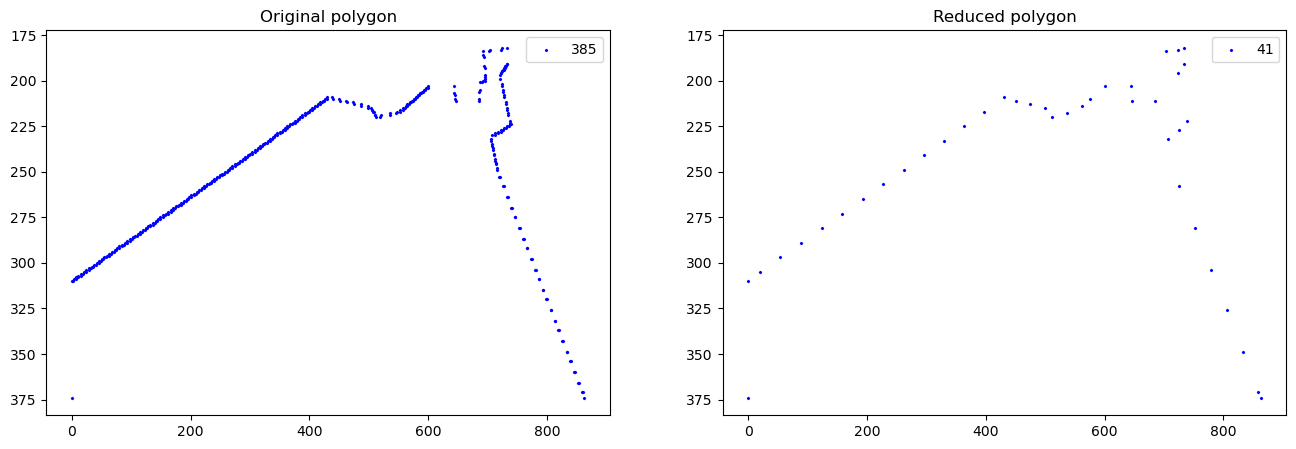



 [bold black] Original_polygon length[/bold black]: 385
 [bold black] Reduced_polygon length[/bold black]: 41
[bold black]Running time[/bold black]: 0.0085 seconds


array([[723, 183],
       [703, 184],
       [685, 211],
       [646, 211],
       [644, 203],
       [600, 203],
       [576, 210],
       [562, 214],
       [536, 218],
       [512, 220],
       [499, 215],
       [475, 213],
       [451, 211],
       [430, 209],
       [397, 217],
       [363, 225],
       [330, 233],
       [296, 241],
       [262, 249],
       [227, 257],
       [193, 265],
       [158, 273],
       [124, 281],
       [ 89, 289],
       [ 54, 297],
       [ 20, 305],
       [  0, 310],
       [  0, 374],
       [863, 374],
       [859, 371],
       [833, 349],
       [806, 326],
       [780, 304],
       [753, 281],
       [726, 258],
       [706, 232],
       [726, 227],
       [738, 222],
       [723, 196],
       [733, 191],
       [733, 182]])

In [19]:
reduced_polygon=reduce_polygon(polygon)
show_result_reducing(polygon)

In [20]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


In [21]:
def normalizeCoordinates(polygon):
    polygon=flatten_list(polygon)
    polygon=np.array(polygon,dtype=np.float64)
    polygon=np.array(polygon,dtype=np.float64)
    polygon[::2]/=WIDTH
    polygon[1::2]/=HEIGHT
    return polygon

In [26]:

def batch_mask2polygon(directory,data="train"):
    os.makedirs(f"./labels/{data}")
    DirFiles=os.listdir(directory)
    i=0
    n=len(DirFiles)
    for filename in DirFiles:
        image = mpimg.imread(f'{directory}/{filename}')
        polygon= mask_to_polygon(RGB2BIN(image))
        try:
            reduced_polygon=reduce_polygon(polygon)
            reduced_polygon=normalizeCoordinates(reduced_polygon)
            reduce_polygon=np.insert(reduced_polygon,0,0)
            str_reduced_polygon= str(reduced_polygon)
            str_reduced_polygon=re.sub(r',|\[|\]|\n','',str_reduced_polygon)
            with open(f'./labels/{data}/{filename.replace(".png","")}.txt', 'w') as f:
                 f.write(str_reduced_polygon)
                
        except:
            polygon=normalizeCoordinates(polygon)
            polygon=np.insert(polygon,0,0)
            str_polygon= str(polygon)
            str_polygon=re.sub(r',|\[|\]|\n','',str_polygon)
            with open(f'./labels/{data}/{filename.replace(".png","")}.txt', 'w') as f:
                 f.write(str_polygon)
        i+=1
        print(f'converted {i} out of {n} items in the directory')



In [45]:
directory='./data/training/gt_image_2/'
DirFiles=os.listdir(directory)
for fileName in DirFiles:
    os.rename(f'{directory}{fileName}', f'{directory}{re.sub(r"lane_|road_","",fileName)}')
    print (fileName)


um_lane_000025.png
um_lane_000027.png
uu_road_000021.png
umm_road_000039.png
umm_road_000046.png
uu_road_000058.png
umm_road_000053.png
umm_road_000064.png
um_road_000042.png
um_lane_000057.png
uu_road_000034.png
um_lane_000015.png
um_road_000012.png
uu_road_000047.png
umm_road_000018.png
uu_road_000007.png
um_lane_000059.png
um_road_000040.png
um_road_000078.png
uu_road_000009.png
um_lane_000026.png
umm_road_000095.png
um_lane_000016.png
um_road_000017.png
umm_road_000093.png
uu_road_000046.png
um_lane_000089.png
uu_road_000097.png
um_lane_000021.png
um_road_000087.png
uu_road_000008.png
um_road_000074.png
um_road_000068.png
uu_road_000030.png
uu_road_000054.png
uu_road_000042.png
uu_road_000082.png
um_road_000006.png
um_road_000047.png
um_lane_000053.png
um_lane_000033.png
umm_road_000021.png
uu_road_000075.png
um_lane_000007.png
um_lane_000054.png
um_lane_000001.png
uu_road_000088.png
umm_road_000024.png
um_lane_000064.png
um_road_000086.png
uu_road_000064.png
umm_road_000086.png
uu

In [27]:
trainMasksDir='./data/training/gt_image_2'
batch_mask2polygon(directory,"train")



converted 1 out of 384 items in the directory
converted 2 out of 384 items in the directory
converted 3 out of 384 items in the directory
converted 4 out of 384 items in the directory
converted 5 out of 384 items in the directory
converted 6 out of 384 items in the directory
converted 7 out of 384 items in the directory
converted 8 out of 384 items in the directory
converted 9 out of 384 items in the directory
converted 10 out of 384 items in the directory
converted 11 out of 384 items in the directory
converted 12 out of 384 items in the directory
converted 13 out of 384 items in the directory
converted 14 out of 384 items in the directory
converted 15 out of 384 items in the directory
converted 16 out of 384 items in the directory
converted 17 out of 384 items in the directory
converted 18 out of 384 items in the directory
converted 19 out of 384 items in the directory
converted 20 out of 384 items in the directory
converted 21 out of 384 items in the directory
converted 22 out of 38

/tmp/ipykernel_44431/1840972825.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(polygons).ravel().tolist()


converted 42 out of 384 items in the directory
converted 43 out of 384 items in the directory
converted 44 out of 384 items in the directory
converted 45 out of 384 items in the directory
converted 46 out of 384 items in the directory
converted 47 out of 384 items in the directory
converted 48 out of 384 items in the directory
converted 49 out of 384 items in the directory
converted 50 out of 384 items in the directory
converted 51 out of 384 items in the directory
converted 52 out of 384 items in the directory
converted 53 out of 384 items in the directory
converted 54 out of 384 items in the directory
converted 55 out of 384 items in the directory
converted 56 out of 384 items in the directory
converted 57 out of 384 items in the directory
converted 58 out of 384 items in the directory
converted 59 out of 384 items in the directory
converted 60 out of 384 items in the directory
converted 61 out of 384 items in the directory
converted 62 out of 384 items in the directory
converted 63 

converted 220 out of 384 items in the directory
converted 221 out of 384 items in the directory
converted 222 out of 384 items in the directory
converted 223 out of 384 items in the directory
converted 224 out of 384 items in the directory
converted 225 out of 384 items in the directory
converted 226 out of 384 items in the directory
converted 227 out of 384 items in the directory
converted 228 out of 384 items in the directory
converted 229 out of 384 items in the directory
converted 230 out of 384 items in the directory
converted 231 out of 384 items in the directory
converted 232 out of 384 items in the directory
converted 233 out of 384 items in the directory
converted 234 out of 384 items in the directory
converted 235 out of 384 items in the directory
converted 236 out of 384 items in the directory
converted 237 out of 384 items in the directory
converted 238 out of 384 items in the directory
converted 239 out of 384 items in the directory
converted 240 out of 384 items in the di